## Unit 3.2 &ndash; Supervised Learning

As we discussed in the previous section, supervised learning is the exercise of predicting an output variable that is known to us based on one or more input variables.
In the process, the algorithm learns parameters that inform a statistical mode.

We have covered at length linear regression and some of its variation; in this section, we are going to focus on more elaborate machine learning techniques in supervised learning.

### Table of Contents

* [Data Preprocessing](#Preprocess)
* [Support Vector Machines](#SVM)
* [Random Forests](#Trees)
* [Neural Networks](#NN)


### Data Preprocessing <a name="Preprocess"></a>

To explore these models, we are going to load a data set of firms' financial ratios and their industry classification. 
Along the way, we are going to cover important data preprocessing steps as well.

In [1]:
import pandas as pd

df = pd.read_csv("./Data/3_Firm_Target.csv", index_col=0)
df.head()

,Sector_Label,Next_MDR,MDR,NI_TA,DEP_TA,Log_TA,FA_TA,RD_TA,Rated,Q,Ind_Median_MDR
0,"Manufacturing (food, beverages, etc.)",0.650291,0.787094,0.031310,0.037861,5.374412,0.323247,0.00000,1.0,0.309797,0.291298
1,Retail trade,0.487760,0.581895,0.027398,0.058719,7.257885,0.572262,0.00000,1.0,0.596380,0.191985
2,"Manufacturing (metal, etc.)",0.171279,0.262006,0.037663,0.027514,5.695496,0.052285,0.01493,0.0,4.180812,0.145438
3,Transportation/warehousing,0.214277,0.256762,0.028804,0.037949,10.340547,1.032685,0.00000,1.0,1.566118,0.300723
4,Transportation/warehousing,0.486185,0.537135,0.022290,0.032150,9.895691,0.669499,0.00000,1.0,0.973849,0.454529


What are the variables?

* `Sector_Label` is the name of the industry of the firm according to the NAICS standard.
* `Next_MDR` and `MDR` are the market debt ratios of the firm, defined as the amount of long term debt a firm has divided by the sum of long term debt and the market value of equity, for the next fiscal year and this fiscal year.
 * We are going to train our machine learning algorithms to predict `Next_MDR` later in this unit.
* `Ind_Median_MDR` is the median market debt ratio of all firms in the firm's industry.
* `Log_TA` is the natural logarithm of the total assets of the firm. A larger value indicates a larger firm as measured by assets.
* `NI_TA` is the firm's profit defined as its net income divided by total assets. This ratio is larger if the firm is more profitable, and it is negative if the firm loses money.
* `DEP_TA` is the firm's recorded depreciation divided by total assets.
* `FA_TA` is the firm's fixed assets compared to total assets.
* `RD_TA` is firm's research and development (R&D) spending compared to total assets
* `Rated` is an indicator variable whether the firm has a credit rating or not.
* `Q` is the firm's ratio of market capitalization to book value of equity. Generally speaking, the higher this ratio, the more growth is priced into the firm's current stock price.

We are going to use these financial ratios to predict the industry of the firms and other firm characteristics. 

We can use the `describe()` function to have a look at some basic statistical features of our data:

In [2]:
df.describe()

,Next_MDR,MDR,NI_TA,DEP_TA,Log_TA,FA_TA,RD_TA,Rated,Q,Ind_Median_MDR
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,0.238849,0.235010,-0.027849,0.053209,5.934104,0.312142,0.047517,0.773600,5.208453e+04,0.182155
std,0.224945,0.220563,0.251201,0.046845,2.099509,0.251877,0.100328,0.418522,5.207988e+06,0.085188
min,0.000002,0.000001,-5.718068,0.000000,0.198977,0.000000,0.000000,0.000000,3.490954e-02,0.040621
25%,0.054197,0.051581,-0.031688,0.028591,4.376444,0.111401,0.000000,1.000000,1.199208e+00,0.125987
50%,0.175441,0.172324,0.029572,0.044266,5.889488,0.236943,0.000000,1.000000,2.054334e+00,0.156857
75%,0.357858,0.358122,0.068537,0.064678,7.344108,0.459206,0.051558,1.000000,3.607471e+00,0.202148
max,0.986865,0.986865,2.685464,1.228507,12.548928,1.142222,0.968336,1.000000,5.207989e+08,0.481340


We observe that the data has vastly different scales. 
The market debt ratio, for example, has a mean and median of 0.23 and 0.17, respectively, and it has a standard deviation of 0.22. 
In contrast, the log of total assets has a mean and median of 5.95 and 5.95, respectively, and it has a standard deviation of 2.13.
If we look more closely, we start to suspect why!
The minimum and maximum for the market debt ratio are 0.00 and 0.99, respectively, while they are 0.45 and 12.41 for the log of total assets

Similar issues may exist for many of the other variables, let's plot histograms!

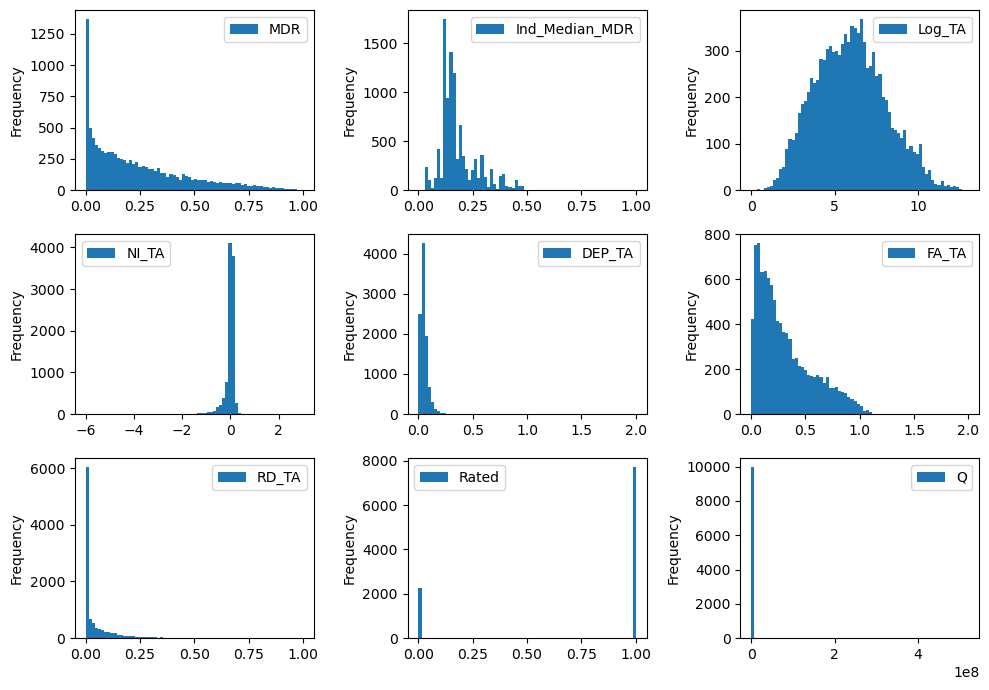

In [3]:
import numpy as np
import matplotlib.pyplot as plt

columns = ["MDR", "Ind_Median_MDR", "Log_TA", "NI_TA",
           "DEP_TA", "FA_TA", "RD_TA", "Rated", "Q"]

fig, axes = plt.subplots(3, 3, figsize=(10, 7))

for col, ax in zip(columns, axes.reshape(-1)):
    col_min = np.floor(df.loc[:, col].min())
    col_max = np.ceil(df.loc[:, col].max())
    df.plot.hist(y=col, bins=np.linspace(col_min, col_max, 71), ax=ax)

plt.tight_layout()

#### Winsorizing Outliers

Some of these variables are ratios and therefore prone to have huge outliers!
Consider for example `NI_TA`, our measure of profitability.
There is a big  peak around zero, but then there are very negative values as well!
Likewise, `Q` has many values around zero, but some in the hundreds or thousands.

Outliers may greatly distort our model, and therefore, we need to deal with them.
A commonly used approach is winsorization which cuts off extreme values.

Consider the following `numpy` array:

In [4]:
values = np.sort(np.array([10, 2, 3, 5, 13, -8, 3, -3, 19, 4]))
values

array([-8, -3,  2,  3,  3,  4,  5, 10, 13, 19])

When we winsorize the data, we replace the most extreme observations with the smallest and highest less extreme observations. 
In our example, `values` is an array of ten numbers. 
If we were to do a 20% winsorization, we would replace the 10% largest and the 10% smallest numbers. 
Here, this procedure amounts to replacing the largest value by the second largest value and the smallest value by the second smallest value:

In [5]:
from scipy.stats.mstats import winsorize

winsorize(values, [0.2, 0.1])

masked_array(data=[ 2,  2,  2,  3,  3,  4,  5, 10, 13, 13],
             mask=False,
       fill_value=999999)

Note how the value `-8` is replaced by `-3` and the value `19` is replaced by `13`.

We apply this method to our variables which are ratios as a 95% winsorization, i.e., trimming the smallest and largest 2.5% of values, and we study the results:

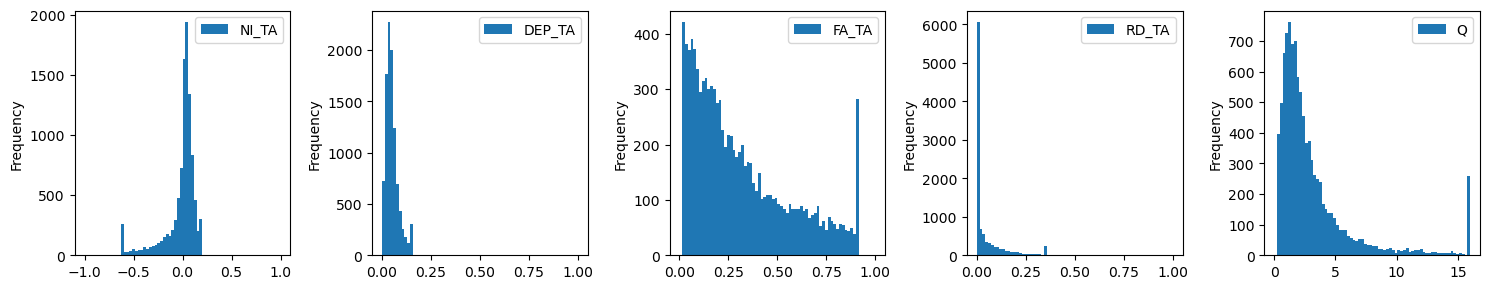

In [6]:
wins_columns = ['NI_TA', 'DEP_TA', 'FA_TA', 'RD_TA', 'Q']

winsorized_df = df.loc[:, wins_columns].apply(winsorize, args=([0.025, 0.025],))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for col, ax in zip(wins_columns, axes.reshape(-1)):
    col_min = np.floor(winsorized_df.loc[:, col].min())
    col_max = np.ceil(winsorized_df.loc[:, col].max())
    winsorized_df.plot.hist(
        y=col, bins=np.linspace(col_min, col_max, 71), ax=ax)

plt.tight_layout()

The histograms show that we are much less exposed to big outliers. 

Note that we have only winsorized the ratios, for they are particularly prone to outliers due to either extremely small or large numerators and denominators. 
Blindly applying the same method of preprocessing to other kinds of data is not necessarily correct. 

We see more of that in the following where we look into demeaning and scaling.

#### Scaling Variables

In our description of the dataset using `describe()`, we find that the means and standard deviation of the variables are greatly different. 
While some machine learning methods are robust to this, like linear regression, others are not!
A feature with a large standard deviation may have a greater than appropriate impact on the result &ndash; while being absolutely meaningless. 
(Linear regression avoids this issue because the coefficients are scaled by the variance of the variables. Other methods do not include this step.)
Therefore, unless the difference in standard deviation is a feature and not a bug, it makes sense to rescale the variables to have mean of zero and standard deviation of one:

$$Z = \frac{X-\mu_X}{\sigma_X},$$

where $X$ is the variable before the transformation and $\mu_X, \sigma_X$ are its mean and standard deviation, respectively. 

Effectively, instead of measuring the variable in its natural units, we measure it in standard deviations from the mean. If $Z=1$, this implies that $X$ is larger than its mean $\mu_X$ by one standard deviation $\sigma_X$.
Since we are trying to explain the behavior in $Y$ by the variation in the values of the $X$'s, this approach is meaningful.

The submodule `preprocessor` of `sklearn` contains the `StandardScaler()` method which performs this transformation. 

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
transformer = scaler.fit(winsorized_df.loc[:, wins_columns])

scaled_values = transformer.transform(winsorized_df.loc[:, wins_columns])

df.loc[:, wins_columns] = scaled_values

df.head()

,Sector_Label,Next_MDR,MDR,NI_TA,DEP_TA,Log_TA,FA_TA,RD_TA,Rated,Q,Ind_Median_MDR
0,"Manufacturing (food, beverages, etc.)",0.650291,0.787094,0.296503,-0.409071,5.374412,0.050954,-0.550129,1.0,-0.852979,0.291298
1,Retail trade,0.487760,0.581895,0.272792,0.233930,7.257885,1.058555,-0.550129,1.0,-0.784844,0.191985
2,"Manufacturing (metal, etc.)",0.171279,0.262006,0.335014,-0.728075,5.695496,-1.045455,-0.360195,0.0,0.340461,0.145438
3,Transportation/warehousing,0.214277,0.256762,0.281315,-0.406387,10.340547,2.428349,-0.550129,1.0,-0.480402,0.300723
4,Transportation/warehousing,0.486185,0.537135,0.241829,-0.585156,9.895691,1.452010,-0.550129,1.0,-0.666340,0.454529


#### Inspecting Scatter Plots

The `pandas` module contains a `plotting` submodule with which we can plot a "matrix" of scatter plots to explore the dependencies and relationships in the data.
This is another important step before we build models, for we need to check for collinearities, i.e., too strong correlations between our chosen variables.

We plot the winsorized and scaled variables below.

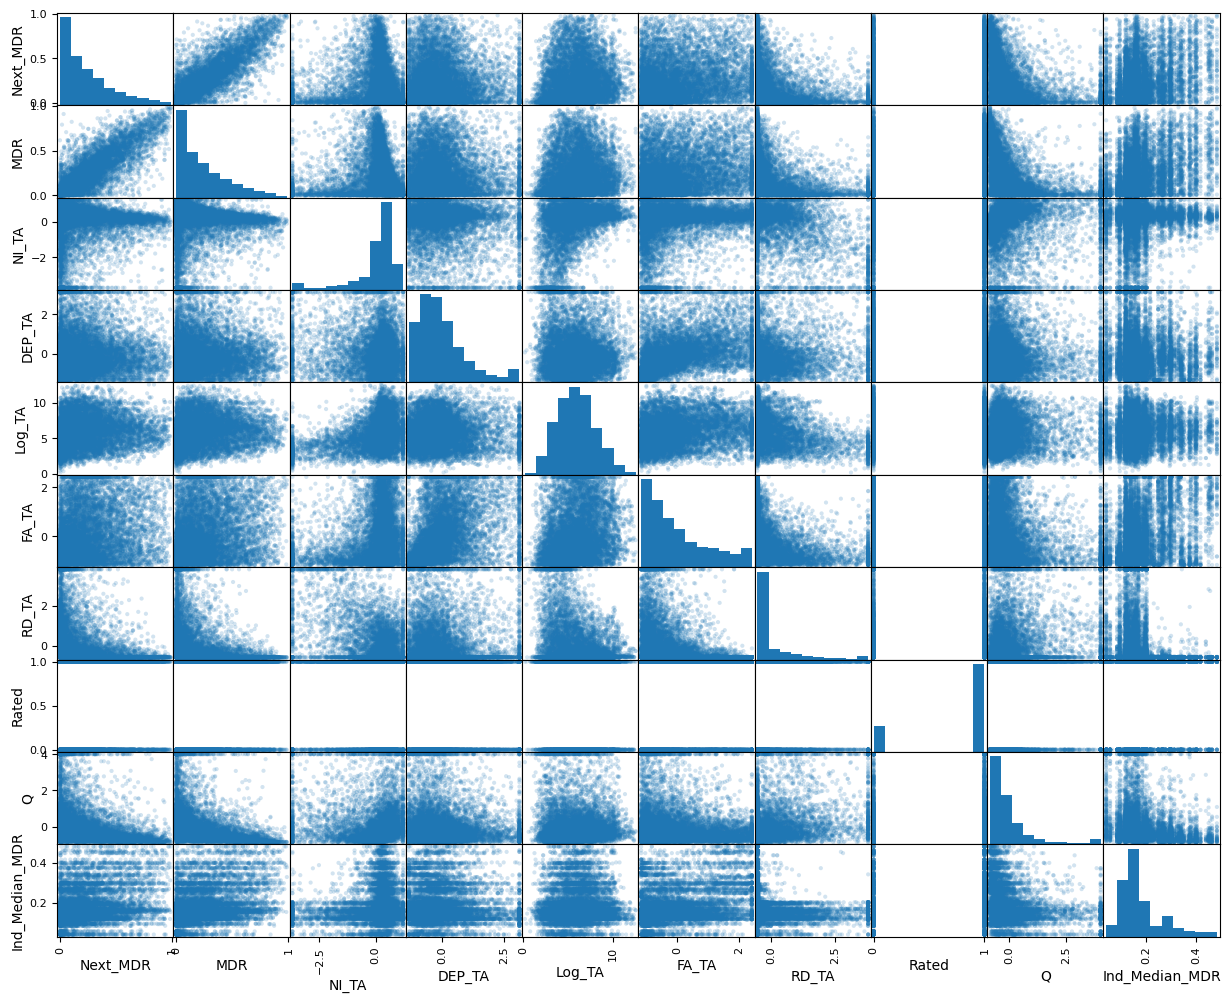

In [8]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(15, 12));

We note some more "trivial" relationships, e.g., the current `MDR` is a decent predictor of `Next_MDR`, and `FA_TA` has some similarities to `DEP_TA`. 
Both of these findings make economic sense! Firms are unlikely to drastically change their capital structure, i.e., their market debt ratio year over year, and firms with greater fixed assets naturally incur more depreciation charges.

#### Label Encoding

To make our target variable, `Sector_Label` employable for supervised learning, we need to transform it into a numerical variable. (After all, our quality of fit or prediction is computed as a number.)

Technically, this problem is not a difficult one. 
Conceptually, though, we are facing another hurdle.

Some categorical data is ordinal, e.g., a letter grade: A is better than B is better than C, and so on. Therefore, if I replace the grades with 4.0, 3.0, 2.0 and so on, I am simply translating this ordinal information into numbers.

Other data, however, is nominal, e.g., an industry label. There is no hierarchy between different labels, and it is not obvious whether "Pharmaceuticals" should get the value 1 and "Oil and Gas" should get the higher value 2, or the other way around!
This seems to be a semantic problem on first inspection, but it is not necessarily for the machine! 
When building relationships between data points, a numerical value of 2 indicates a signal that is stronger than a numerical value of 1. 
This relationship works for ordinal data, but it makes no sense for nominal data...

Therefore, we need to discuss two different encoding methods: label encoding and one-hot encoding.

* *label encoding* translates ordinal categories into numbers, e.g., letter grades into numerical grades.
* *one-hot encoding* translates nominal categories into dummy variables.
 * If we have three industries, like *Mining*, *Construction* and *Retail*, the encoded variable would be `[1, 0, 0, ]` for *Mining*, `[0, 1, 0]` for *Construction* and `[0, 0, 1]` for *Retail*.
 
To apply label encoding, we can use a `preprocessing` function from `sklearn`.

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded = le.fit_transform(df.loc[:, "Sector_Label"].values)

encoded[0:10]

array([ 7, 12,  8, 13, 13,  8,  8,  0, 11,  8])

To apply one-hot encoding, we can use the `pandas` function `get_dummies()`. 

In [10]:
pd.get_dummies(df.loc[:, "Sector_Label"]).head()

,Accommodation and food services,"Agriculture, forestry, fishing, and hunting","Arts, entertainment, and recreation",Construction,Educational services,Health care and social assistance,Information,"Manufacturing (food, beverages, etc.)","Manufacturing (metal, etc.)","Manufacturing (wood, etc.)",Mining,"Professional, scientific, and technical services",Retail trade,Transportation/warehousing,Wholesale trade
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Importantly, independent variables, i.e., our predictors must be encoding using one-hot encoding if they are nominal but not ordinal! 
Otherwise, our models will yield spurious models that make unfounded predictions!

### Support Vector Machines <a name="SVM"></a>

Support vector machines (SVM) are a powerful machine learning model that is frequently used for both regression and classification. 
SVMs draw decision boundaries and are considered particularly effective for complex but small to medium data sets when more data-hungry models are inappropriate.

To gain an intuition behind SVMs, let us consider a sample from our dataset above. 
We select 25 firms from the industries "Information" and "Mining". 
Then we plot as a scatter plot their scaled values for the depreciation to total assets and fixed assets to total assets.

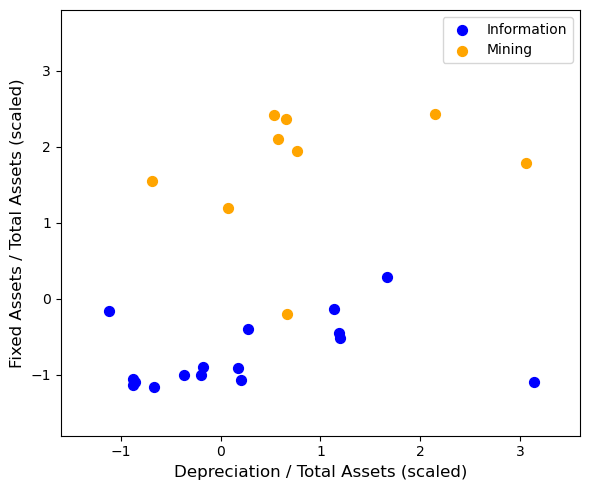

In [11]:
ind_1, ind_2 = "Information", "Mining"
var_1, var_2 = "DEP_TA", "FA_TA"

sample_df = df.loc[df["Sector_Label"].isin([ind_1, ind_2])].iloc[0:25]


fig, ax = plt.subplots(figsize=(6, 5))

sample_df.loc[sample_df["Sector_Label"] == ind_1].plot.scatter(x=var_1, y=var_2,
                                                               ax=ax, c="blue", s=50,
                                                               label=ind_1)
sample_df.loc[sample_df["Sector_Label"] == ind_2].plot.scatter(x=var_1, y=var_2,
                                                               ax=ax, c="orange", s=50,
                                                               label=ind_2)

ax.set_xlabel("Depreciation / Total Assets (scaled)", fontsize=12)
ax.set_ylabel("Fixed Assets / Total Assets (scaled)", fontsize=12)
ax.set_xlim(-1.6, 3.6)
ax.set_ylim(-1.8, 3.8)

plt.tight_layout()

We observe that the mining firms have higher fixed assets ratio given the same level of depreciation than do information firms.
If we were to now draw a decision line, we would want the line to capture as wide a *margin* as possible between the two groups. 

However, often times the data is not clear cut at all; if we include more data points, the following picture emerges:

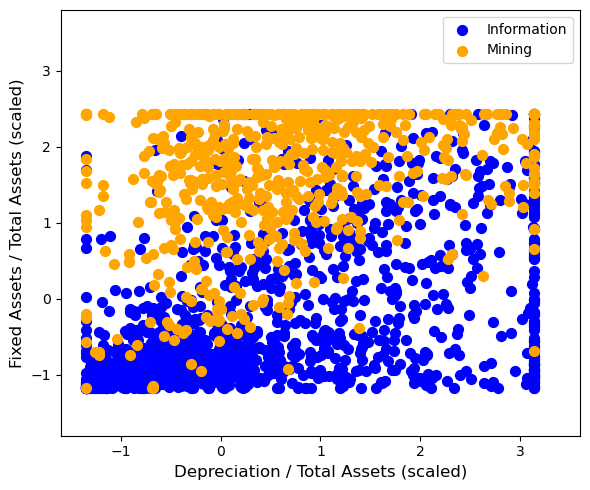

In [12]:
ind_1, ind_2 = "Information", "Mining"
var_1, var_2 = "DEP_TA", "FA_TA"

sample_df = df.loc[df["Sector_Label"].isin([ind_1, ind_2])]


fig, ax = plt.subplots(figsize=(6, 5))

sample_df.loc[sample_df["Sector_Label"] == ind_1].plot.scatter(x=var_1, y=var_2,
                                                               ax=ax, c="blue", s=50,
                                                               label=ind_1)
sample_df.loc[sample_df["Sector_Label"] == ind_2].plot.scatter(x=var_1, y=var_2,
                                                               ax=ax, c="orange", s=50,
                                                               label=ind_2)

ax.set_xlabel("Depreciation / Total Assets (scaled)", fontsize=12)
ax.set_ylabel("Fixed Assets / Total Assets (scaled)", fontsize=12)
ax.set_xlim(-1.6, 3.6)
ax.set_ylim(-1.8, 3.8)

plt.tight_layout()

We still observe that the original insight remains true, but the point clouds are starting to significantly overlap!
Therefore, our decision boundary has to be considered fuzzy; being on one side or the other indicates a higher likelihood to be in one or the other industry.

* *Hard-margin classification* requires us to be able to separate the data without any overlap, i.e., there must not be any data point that falls onto the wrong side of the decision boundary. 
* *Soft-margin classification* relaxes the hard constraint and instead tries to minimize the number of violations while separating the groups as much as possible. This method is less prone to suffer from the impact of outliers.

Before we move on to classification, we need to translate the industry label into a numerical value.
Since we only consider two categories, we need not worry about the difference between ordinal or nominal.
(This difference only starts to matter for more than two categories, i.e., when we have to wonder if there is an order or hierarchy to the values).
Therefore, we use the `LabelEncoder`.

(You may safely ignore the warning.)

In [13]:
from sklearn.svm import LinearSVC

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
sample_df.loc[:, "Sector"] = le.fit_transform(
    sample_df.loc[:, "Sector_Label"].values)


X = sample_df.loc[:, [var_1, var_2]].values
y = sample_df.loc[:, "Sector"].values

svm_clf = LinearSVC(C=0.2)
svm_clf.fit(X, y)

/var/folders/j4/328k7pk14cd54l609cmlhpv04hc928/T/ipykernel_78081/875904237.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.loc[:, "Sector"] = le.fit_transform(


LinearSVC(C=0.2)

The parameter `C` determines how soft the margin is; the lower its value, the more margin violations are allowed and the bigger the margin between the groups, and vice versa.

Let us look at its impact and our findings.
To this end, we use a function `plot_decision_boundary()`.

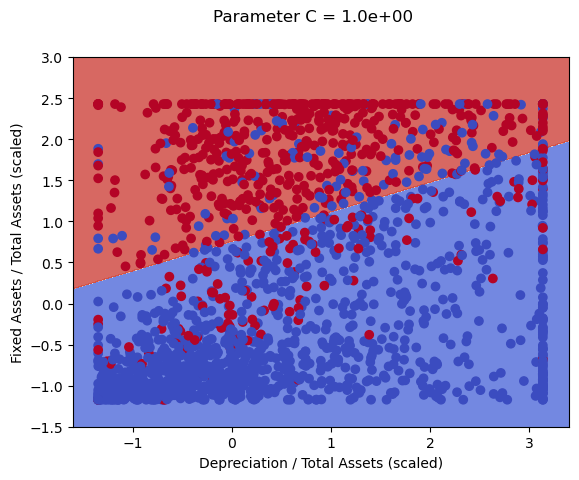

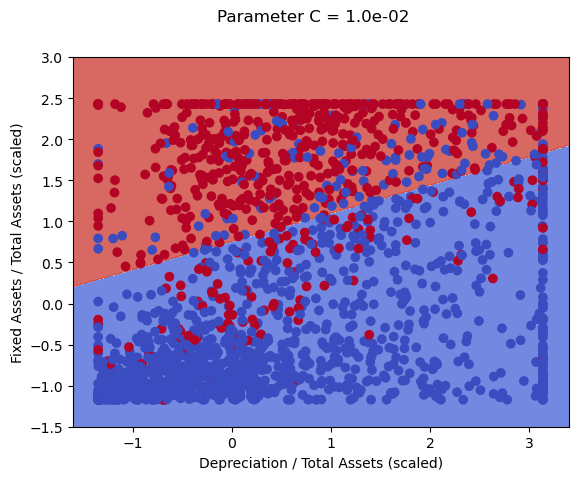

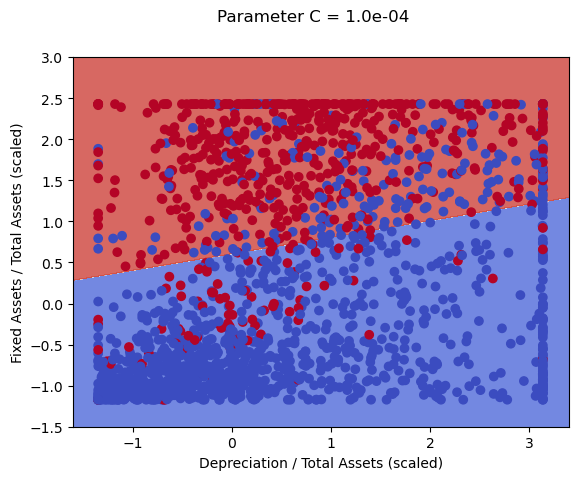

In [14]:
def plot_decision_boundary(model, X, y, x_lim, y_lim, mesh,
                           x_label="X_1", y_label="X_2", title=None):
    # Define the minimum and maximum values as passed to the function.
    x_min, x_max = x_lim
    y_min, y_max = y_lim

    # Create a grid of many data points to evaluate the model at.
    xx, yy = np.meshgrid(np.arange(x_min, x_max+mesh, mesh),
                         np.arange(y_min, y_max+mesh, mesh))

    # Make predictions at each data point.
    predictions = model.predict(np.c_[xx.ravel(), yy.ravel()])
    predictions = predictions.reshape(xx.shape)

    # Plot a contour plot for the predictions.
    plt.contourf(xx, yy, predictions, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    if title is not None:
        plt.suptitle(title)

    plt.show()


Cs = [1, 1e-2, 1e-4]
for C in Cs:
    # Set up a linear separator with parameter C.
    # Use up to 10,000 iterations to find the solution.
    svm_clf = LinearSVC(C=C, max_iter=10000)
    model = svm_clf.fit(X, y)
    plot_decision_boundary(model, X, y, (-1.6, 3.4), (-1.5, 3), 0.005,
                           x_label="Depreciation / Total Assets (scaled)",
                           y_label="Fixed Assets / Total Assets (scaled)", 
                           title="Parameter C = {:.1e}".format(C))

In [15]:
sample_df.describe()

,Next_MDR,MDR,NI_TA,DEP_TA,Log_TA,FA_TA,RD_TA,Rated,Q,Ind_Median_MDR,Sector
count,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000,1931.000000
mean,0.215917,0.201291,-0.166133,0.529920,6.192537,0.308912,-0.049316,0.659244,0.145227,0.142464,0.320559
std,0.203793,0.196181,1.123643,1.293554,2.272901,1.272701,0.985752,0.474086,1.068677,0.066878,0.466812
min,0.000008,0.000008,-3.696475,-1.346558,0.198977,-1.171258,-0.550129,0.000000,-0.852979,0.040621,0.000000
25%,0.048236,0.035194,-0.400250,-0.516134,4.457377,-0.899404,-0.550129,0.000000,-0.508575,0.116976,0.000000
50%,0.163654,0.148024,0.218868,0.273323,6.125149,-0.107025,-0.550129,1.000000,-0.204276,0.118756,0.000000
75%,0.316428,0.304341,0.488477,1.369556,7.740409,1.534343,-0.065885,1.000000,0.322593,0.169021,1.000000
max,0.981717,0.933565,1.216384,3.136082,12.394278,2.428349,3.818015,1.000000,4.007784,0.293507,1.000000


Evaluating the three outputs, we see that `C=1` and `C=1e-2` broadly separate the groups, albeit with numerous margin violations; there are many "blue" dots (oil and gas firms) in the red region (retail firms) and vice versa.
However, looking at the results for a much lower value of `C=1e-4`, we note that the decision boundary is not closely aligned with the proper classifications.

We can confirm our visual impression with the accuracy score:

In [16]:
from sklearn.metrics import accuracy_score

for C in Cs:
    svm_clf = LinearSVC(C=C)
    model = svm_clf.fit(X, y)
    print("C = {:.1e}. Accuracy: {:.3f}".format(C, accuracy_score(y, model.predict(X))))

C = 1.0e+00. Accuracy: 0.872
C = 1.0e-02. Accuracy: 0.872
C = 1.0e-04. Accuracy: 0.851


In general, though, the linear separation between the two groups is not great, and we need a more complex function to draw the boundary, e.g., a polynomial.

At this point, it is useful to introduce the `pipeline` submodule. 
With the functionality in this submodule, we can combine multiple steps like transformations and estimate a model based on the transformed data.

Therefore, to build a model, we do these steps:

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Set up a pipeline
polynomial_svm_clf = Pipeline([
    # Transform the variables into polynomials up to order 3.
    ("poly_features", PolynomialFeatures(degree=3)),
    # Create the model.
    ("svm_clf", LinearSVC(C=1e-2))
])

poly_model = polynomial_svm_clf.fit(X, y)

To compare different models, we are plotting the decision boundary and regions for different order polynomials.

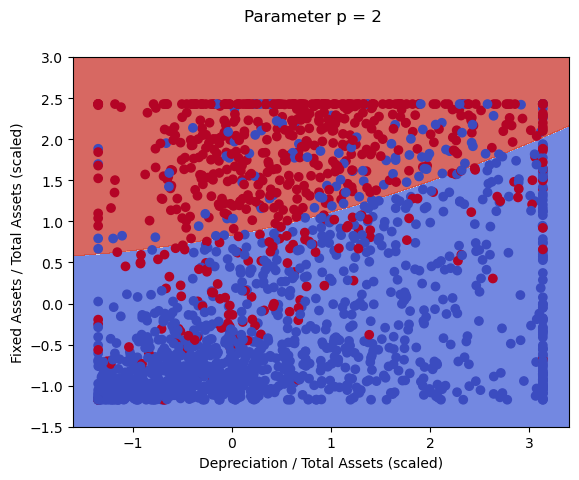

p = 2. Accuracy: 0.868


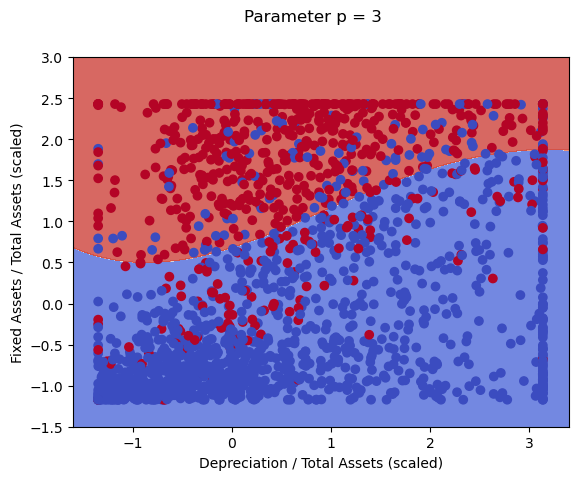

p = 3. Accuracy: 0.872


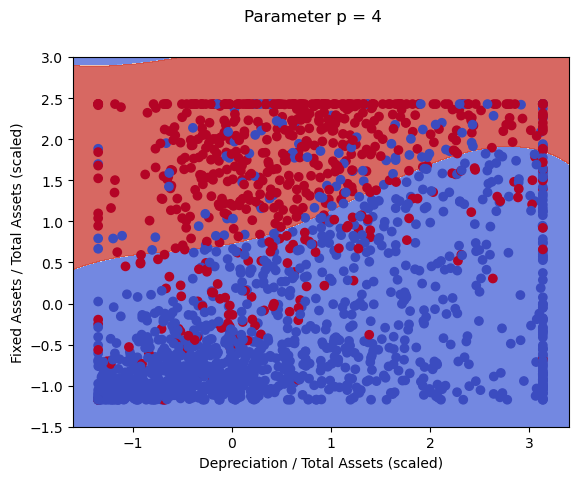

p = 4. Accuracy: 0.873


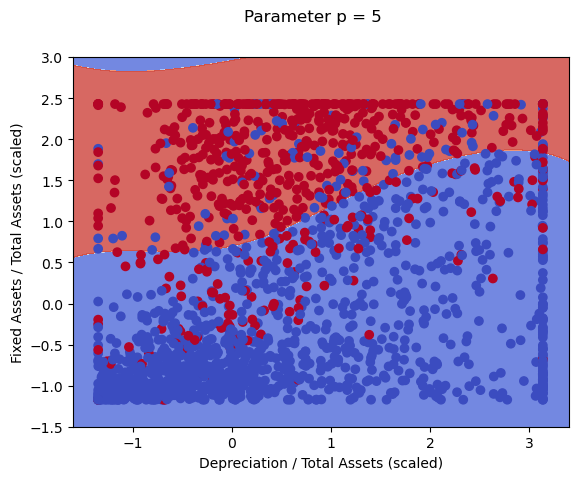

p = 5. Accuracy: 0.872


In [18]:
for p in [2, 3, 4, 5]:
    polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=p)),
        ("svm_clf", LinearSVC(C=1e-2, max_iter=1e5))
    ])
    
    poly_model = polynomial_svm_clf.fit(X, y)
    plot_decision_boundary(poly_model, X, y, (-1.6, 3.4), (-1.5, 3), 0.005,
                           x_label="Depreciation / Total Assets (scaled)",
                           y_label="Fixed Assets / Total Assets (scaled)", 
                           title="Parameter p = {}".format(p))
    print("p = {}. Accuracy: {:.3f}".format(
        p, accuracy_score(y, poly_model.predict(X))))

With the parameter `C` we have chosen, there is a small improvement in the accuracy if we increase higher order terms of a polynomial, including combinations like `DEP_TA*FA_TA`. 
However, we also ought to suspect some degree of overfitting, e.g., the appearance of a blue area for high fixed assets to total assets!

Another way to improve the performance and the flexibility of a SVM is to introduce a kernel. 
In our polynomial transformation above we need to compute all combinations of the two variables, that is, for the 8th polynomial, for example, $X_1^8, X_1^7X_2, X_1^6X_2^2, \dots$. 
While we are able to cover higher order interaction terms, this procedure is computationally expensive. 
Instead, we can use a kernel; the polynomial kernel is one of many possible ways to transform the data.
Another popular one is the Gaussian RBF kernel for which we need to pass the parameter `gamma`. 
Effectively, the kernel measures the similarity of the two scaled variables (cash-to-debt and price-to-sales); a large `gamma` implies that only very close scaled variables are considered to be similar.

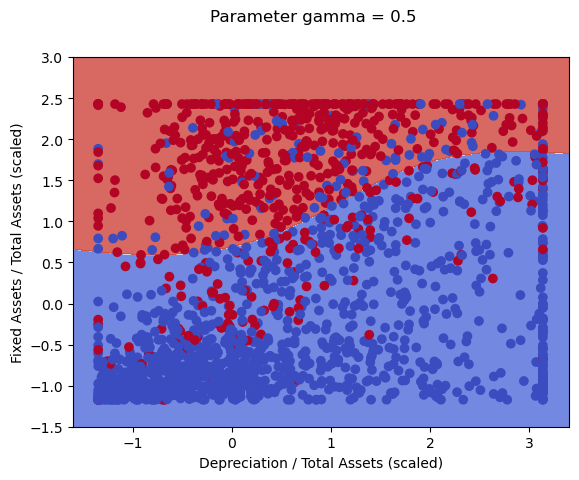

gamma = 0.5. Accuracy: 0.871


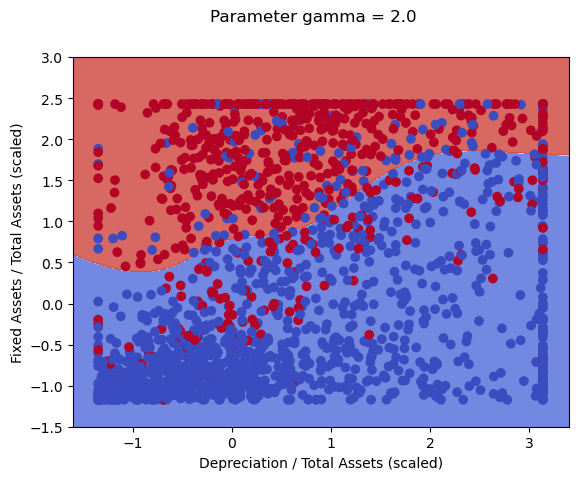

gamma = 2.0. Accuracy: 0.874


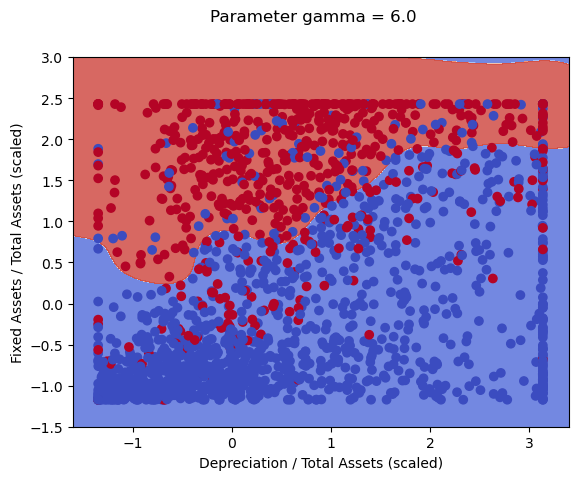

gamma = 6.0. Accuracy: 0.878


In [19]:
from sklearn.svm import SVC

for gamma in [0.5, 2, 6]:
    gaussian_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(C=1, kernel="rbf", gamma=gamma))
    ])
    gaussian_model = gaussian_svm_clf.fit(X, y)
    plot_decision_boundary(gaussian_model, X, y,  (-1.6, 3.4), (-1.5, 3), 0.005,
                           x_label="Depreciation / Total Assets (scaled)",
                           y_label="Fixed Assets / Total Assets (scaled)",
                           title="Parameter gamma = {:.1f}".format(gamma))
    print("gamma = {:.1f}. Accuracy: {:.3f}".format(
        gamma, accuracy_score(y, gaussian_svm_clf.predict(X))))

We are able to draw much more complex decision boundaries, and improve &ndash; in-sample &ndash; the accuracy.
The more complex decision boundaries are, the more closely we can fit the data. But again: beware of overfitting!

Note that these examples may not stand up to a serious test of our model and aim solely to illustrate the implementation of a SVM; whether the price-to-sales and cash-to-debt ratios well predict the industry of a firm needs further testing.
Similarly, a major challenge of implementing machine learning models is the right choice (or tuning) of the *hyperparameters* such as the order of the polynomial or value of `gamma`.

<div class="alert alert-info">
    <h2>Case Study: Capital Structure Adjustments</h2><p></p>
    A major decision executives must make is on the capital structure of the firm. More specifically, what should be the mix of debt and equity for the firm? 
    Researchers have been studying this topic and used firm variables like the ones we have loaded above to predict a firm's market debt ratio.
    <p></p>
    In our case study, we will first run an ordinary least squares regression of the data to predict <code>Next_MDR</code> based on the variables we have collected, and we use this result as a benchmark to compare the decision trees against.
    To get started, we separate our data set in train and test sets to compare the different algorithms, using 20% of our data for the test set.
</div>

In [20]:
from sklearn.model_selection import train_test_split

X = df.loc[:, ["MDR", "Ind_Median_MDR", "Log_TA", "NI_TA",
               "DEP_TA", "FA_TA", "RD_TA", "Rated", "Q"]]
y = df.loc[:, "Next_MDR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<div class="alert alert-info">
    Next we estimate the linear regression model as our baseline.
</div>

In [21]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

# Fit the linear regression
linreg.fit(X_train, y_train)

# Store the coefficients in a data frame and output the results.
linreg_df = pd.DataFrame(
    data=linreg.coef_, index=X.columns, columns=["Coefficient"])
linreg_df

,Coefficient
MDR,0.847063
Ind_Median_MDR,-0.006836
Log_TA,0.001017
NI_TA,-0.006646
DEP_TA,-0.007141
FA_TA,0.004814
RD_TA,-0.010314
Rated,-0.018614
Q,0.001441


<div class="alert alert-info">
    The model has an in-sample $R^2$ of 73.1%, and a slightly lower out-of-sample $R^2$ of 72.4%:
</div>

In [22]:
print("In-sample R-squared = {:.1f}%".format(100*linreg.score(X_train, y_train)))
print("Out-of-sample R-squared = {:.1f}%".format(100*linreg.score(X_test, y_test)))

In-sample R-squared = 72.0%
Out-of-sample R-squared = 72.5%


<div class="alert alert-info">
    Another conventional measure for quality of fit is the mean squared error (MSE), sometimes also called the mean squared forecast error (MSFE): 
</div>

In [23]:
from sklearn.metrics import mean_squared_error as mse

print("In-sample MSE = {:.5f}".format(mse(y_train, linreg.predict(X_train))))
print("Out-of-sample MSE = {:.5f}".format(mse(y_test, linreg.predict(X_test))))

In-sample MSE = 0.01431
Out-of-sample MSE = 0.01340


<div class="alert alert-info">
    As expected, out of sample the model performs slightly worse as indicated by the higher MSE. In the following, we will test different models.
</div>

### Random Forests <a name="Trees"></a>

In a classic demonstration of the "wisdom of the crowds", Sir Francis Galton asked villagers to estimate the weight of an ox &ndash; and while no individual was an expert and no guess was correct (and some guesses were far off the mark), the averaged response was accurate within a couple of pounds!

There is a similar approach in machine learning to harness the equivalent to the wisdom of the crowds, and it is called *ensemble learning*. 
We train a number of classification or decision trees on different subsets of the data, and then we aggregate the output of our individual predictions.
Similarly, we can train a number of regressions and evaluate their output.

In our case study, our base case is an ordinary least squares regression, and we therefore employ the `RandomForestRegressor` method. 
This algorithm runs regressions on random samples of the data, with replacement. 
As a result, some observations may be fed to the regression multiple times while others are not included in a given sample. 
Then the results of these separate regressions are averaged.
This procedure has two benefits: it improves the accuracy and it tends to be less affected by overfitting.
Further, at each critical juncture, the tree selects a subset of features to make its predictions and not the whole list of features. 
If one feature were overshadowing the other ones in importance for the training set, we would diminish its impact this way. This step also reduces the correlation between the results of individual trees.

In [24]:
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(random_state=0)
rfreg.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Per the default settings of `RandomForestRegressor`, the regression forest consists of 100 trees, i.e, regressions on 100 different samples of the data.

In [25]:
print("IS R-squared  = {:.1f}%".format(100*rfreg.score(X_train, y_train)))
print("OOS R-squared = {:.1f}%".format(100*rfreg.score(X_test, y_test)))

IS R-squared  = 96.1%
OOS R-squared = 71.7%


In [26]:
print("IS MSE  = {:.5f}".format(mse(y_train, rfreg.predict(X_train))))
print("OOS MSE = {:.5f}".format(mse(y_test, rfreg.predict(X_test))))

IS MSE  = 0.00197
OOS MSE = 0.01380


In-sample, random forests of regression trees yield spectacular results. 
At the same time, the out-of-sample $R^2$ and MSE are still better than for ordinary least squares regression &ndash; without making any adjustments to find the best hyperparameters for the random forest model!

An alternative to random forests of regression trees are *gradient boosted regression trees*, in which the trees are not trained independently and in parallel, but in sequence in order to improve the previously trained tree.

Using `GradientBoostingRegressor()`, we are also going to explore hyperparameter tuning. 
Setting up a machine learning model, be it a gradient boosted regression tree, a random forest or a support vector machine, we have to decide on a number of hyperparameters.

* For support vector machines, we have to decide on the strictness of the margin, and if we were using kernels, we have to decide on which kernel and on the details of the chosen kernel.
* For random forests, we have to decide on the size of the samples we are using (full data set or smaller), the depth of the trees, e.g., how deeply we drill down into the data, etc.
* For gradient boosted regression trees, we also have to decide on the nature of the sequential learning.

How would we go about this procedure? 
We want to choose hyperparameters that yield the lowest out-of-sample error, i.e., describe unknown data best and therefore have not suffered from overfitting.

Let us consider the parameter `n_estimators` for `GradientBoostingRegressor()`. 
It sets the number of trees the boosted regression goes through; with each tree, the previous result is improved.
This is where the danger of overfitting looms; if we use too many trees, we might get a result that is too specific to our training data and will not generalize well.

The method `staged_predict()` of the gradient boosted regression tree allows us to evaluate our results after each such step. 
With this method, we determine the ideal stopping point.

To do this, we first set up the gradient boosted regression trees and initialize `n_estimators` to be 200, allowing for up to 200 trees.

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gbreg = GradientBoostingRegressor(n_estimators=200, random_state=0)
gbreg.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=200, random_state=0)

We proceed to determine the MSE for each step.

The OOS MSE is minimal for n_estimates = 96


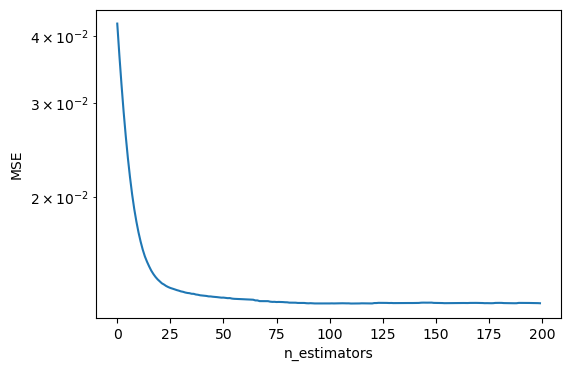

In [28]:
errors = [mse(y_test, y_pred)
          for y_pred in gbreg.staged_predict(X_test)]
best_n = np.argmin(errors)

print("The OOS MSE is minimal for n_estimates = {}".format(best_n))

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(errors)
ax.set_xlabel("n_estimators")
ax.set_ylabel("MSE")
ax.set_yscale("log");

Note how the error is very large for a small number of regression trees and then stays at a fairly low level after bottoming at 96 estimators.

We proceed to test the model with 96 estimators.

In [29]:
best_gbreg = GradientBoostingRegressor(n_estimators=96, random_state=0)
best_gbreg.fit(X_train, y_train)

print("IS R-squared  = {:.1f}%".format(100*best_gbreg.score(X_train, y_train)))
print("OOS R-squared = {:.1f}%".format(100*best_gbreg.score(X_test, y_test)))

print("IS MSE  = {:.5f}".format(mse(y_train, best_gbreg.predict(X_train))))
print("OOS MSE = {:.5f}".format(mse(y_test, best_gbreg.predict(X_test))))

IS R-squared  = 76.9%
OOS R-squared = 74.1%
IS MSE  = 0.01178
OOS MSE = 0.01264


With these results, we are able to further improve upon  the findings from the random forest, which yielded a greater accuracy than the ordinary least squares regression.

### Neural Networks <a name="NN"></a>

Neural Networks are often used synonymously with machine learning.
However, they are simply one of the more advanced and elaborate methods for making predictions based on data.

A neural network has the following basic setup:

* An input layer to which we pass the features of the data, where each feature corresponds to a node.
* An output layer which yields the prediction, where each output dimension corresponds to a node.
* One or more hidden layers which explore how the features are useful in making predictions.

If you will, a regression is the simplest kind of neural network in which there are no hidden layers. 
A regression model takes the features from the data into its "input layer" and yields a prediction in its "output layer". 

Just like the coefficients in a regression are quintessential, so are the *weights* of the links in the neural networks that connect the nodes.
A basic illustration[^1] below shows a neural network with one hidden layer.

<img src="./3_NN.png" width=300></img>

[^1]: Wikipedia, authored by user Wiso, 2008.

The nodes in the input layer feed into the nodes in the hidden layer with different amplification, based on the weights of the links.
Within the nodes in the hidden layer, there is an activation function to decide whether to relay the input further, and if so, how strongly. 
The activation function is non-linear, i.e., information is not simply passed on.
It may be suppressed completely if it falls below a threshold, or it might be passed through in its original form, or anything between.

A major library for the implementation of neural networks is `TensorFlow`. 
However, it is also a very technical library, and therefore, we are going to focus on the `keras` package which is a high-level API built on `TensorFlow`. 
`keras` reduces the complexity, at the cost of reducing the flexibility &ndash; for an introduction into neural networks, this compromise is a good one!

Refer to the documentation of the `keras` package:

>Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result as fast as possible is key to doing good research.
>
> Keras is:
>
> * Simple &ndash; but not simplistic. Keras reduces developer cognitive load to free you to focus on the parts of the problem that really matter.
> * Flexible &ndash; Keras adopts the principle of progressive disclosure of complexity: simple workflows should be quick and easy, while arbitrarily advanced workflows should be possible via a clear path that builds upon what you've already learned.
> * Powerful &ndash; Keras provides industry-strength performance and scalability: it is used by organizations and companies including NASA, YouTube, and Waymo.

To get started with `keras`, you need to add to your Python distribution `TensorFlow`.
(Formerly standalone, Tensorflow has now included Keras as a submodule.)

We start by importing the submodules `models` and `layers` from `keras`. 
Since the entire library is sizable, selective imports are recommended.

The `models` submodule allows us to set up the model. 
We typically choose the `Sequential()` model object in which layers are worked off sequentially.
The `layers` module allows us to populate the model with input, output and hidden layers and set their properties.

We then build a model that consists of three hidden layers and one output layer. 
The first three added layers have 100, 20 and 50 nodes, respectively.
For the first layer, we specify that we want to pass the right number of arguments, which are our nine preprocessed variables in the data frame `df`.
The last layer (the output layer) has one node, for we want to predict `Next_MDR` which is one-dimensional.

The code below demonstrates the range of different activation functions.
In a real project, we need to carefully choose the activation functions, for they differ in computational complexity and usefulness.
For our output layer, we need to be even more deliberate because the form of the activation function determines the range of values that come out. 

* `relu`, short for rectangular linear unit, is zero for negative numbers and then grows linearly for positive numbers. The range of possible values is zero to infinity. This choice does not work for `Next_MDR` which is between 0 and 1.
* `softplus` is a smoothed out version of `relu`, particularly around values close to zero.
* `sigmoid` and `softmax` are S-shaped curves ranging from zero to one. The former works only for the output is binary, while the latter works for multiple possible outputs, being a generalization of the `sigmoid` function. Both of these choices would work for our purposes.

In [32]:
from keras import models, layers

nnmod = models.Sequential()

nnmod.add(layers.Dense(units=100, activation="softmax", input_shape=(X.shape[1], )))
nnmod.add(layers.Dense(units=20, activation="relu"))
nnmod.add(layers.Dense(units=50, activation="softplus"))
nnmod.add(layers.Dense(units=1, activation="sigmoid"))

We then compile the model specifying the following: 

* `loss`: The weights of the neural network are trained iteratively, taking into account the error made in the models predictions. The loss function specifies how this error is computed.
 * The right choice of loss function depends on the output data. If we have continuous target data like in our example, a mean squared error is appropriate; if we have categorical data like sector labels, then a different measure would be appropriate.
* `optimizer`: We specify the procedure by which the neural network weights are to be learned.
 * The proper choice for the optimizer depends, among other things, on the input data. If the data is very sparse, then some optimizers might run ineffectively and use a lot of resources. 
 
Finally, we pass the data to the model and fit. 
Note that we *cannot* pass `pandas` data frames, and instead we must translate them into `numpy` arrays first.


In [33]:
nnmod.compile(loss='mean_squared_error',
              optimizer='sgd')

nnmod.fit(X_train.values, y_train.values, epochs=5, batch_size=32)

Epoch 1/5
250/250 [==============================] - 1s 579us/step - loss: 0.0555
Epoch 2/5
250/250 [==============================] - 0s 560us/step - loss: 0.0511
Epoch 3/5
250/250 [==============================] - 0s 564us/step - loss: 0.0511
Epoch 4/5
250/250 [==============================] - 0s 548us/step - loss: 0.0511
Epoch 5/5
250/250 [==============================] - 0s 566us/step - loss: 0.0511


Lastly, we compute the loss metrics on the test set, which in our case is the MSE.

In [34]:
loss_and_metrics = nnmod.evaluate(X_test.values, y_test.values, batch_size=128)
loss_and_metrics

16/16 [==============================] - 0s 718us/step - loss: 0.0488


0.04882238432765007

Note that our neural network performs much more poorly than the other methods introduced here.
There are a number of simple explanations for this: The great degree of complexity in a neural network requires careful choice of the hyperparameters; we need to carefully guard ourselves against overfitting; we need to set up the neural network deliberately in our choices of layer sizes and activation functions.

Neural networks are a very powerful tool for predictive analysis. 
With this power comes great responsibility: data integrity, proper data transformations and an accurate model setup are critical.

To demonstrate what could go wrong, consider the following findings relating to the COVID-19 pandemic, which were derived using a poorly prepared data set and with significant overfitting.
Researchers were trying to identify from chest scans whether the patients were at risk of serious COVID-19 disease, but: 

* Many researchers used data sets with a large number of chest scans of children who did not have COVID-19. As a result, the model effectively identified children and not COVID-19.
* Some chest scans in the data set were performed on patients laying down, while others were standing up. The AI learned that the position of the patient was a good predictor of COVID-19. However, this finding is old news: seriously ill patients had to be scanned laying down, while less ill or healthy patients would be standing up.
* The scans had supporting text on them which would have a different font and font size based on the hospital. However, some hospitals had much higher case loads, and the model would assume the font to be a predictor of COVID-19 for it found that relationship.

In all cases, the model picked up spurious correlations!

While this unit has offered a technical description of how to implement models, it does not demonstrate how to properly implement a model to avoid all the issues described above. 
A more comprehensive course is needed for that!